In [1]:
!pip install gcm-filters -q

In [2]:
!pip install gsw -q

In [3]:
!pip install numpy_groupies -q

In [4]:
!pip install xrft --upgrade -q

# Dask start

In [5]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36001")
client

<Client: 'tcp://127.0.0.1:36001' processes=4 threads=8, memory=29.40 GiB>

# Import

In [6]:
import s3fs
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import gsw
import gcm_filters
from xhistogram.xarray import histogram
import eos_module
from dask import compute
from dask.diagnostics import ProgressBar
from dask import delayed
import xrft_module
import pandas as pd
import xesmf as xe
import cartopy.crs as ccrs
from scipy.stats import kurtosis, skew, describe
import pandas as pd
import xrft

In [7]:
# import imp
# imp.reload(xrft_module)

# Load data

## eNATL60

Load Pangeo catalog

In [8]:
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [9]:
# x_slice = slice(400,700)
# y_slice = slice(500,800)

x_slice = slice(0,-1)
y_slice = slice(0,-1)

#resampling_avg_period = '96h'
data_slice = dict(time_counter=slice(0,-1,50),y=y_slice,x=x_slice)

coord_slice = dict(y=y_slice,x=x_slice)

In [10]:
nb_of_time_chunks = 7

In [11]:
%%time
dataSetsHR=[]

for region in ['1', '2', '3'] :
    for season in ['fma', 'aso'] :
        current_set = cat.eNATL60(region=region,datatype='surface_hourly', season=season).to_dask().\
        drop(['fmask','qt_oce', 'somecrty','sometauy','sossheig','sowaflup','sozocrtx','sozotaux','umask','vmask'],errors='ignore')
        current_set.coords['tmask'] = current_set.tmask.astype(np.float32)
        #current_set = current_set.resample({'time_counter' : resampling_avg_period}, closed='right', label='right').mean()
        current_set = current_set.isel(data_slice)
        current_set = current_set.chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
        current_set.load()
        current_set['x'] = np.arange(len(current_set['x']))
        current_set['y'] = np.arange(len(current_set['y']))
        dataSetsHR.append({'region': region, 'season' : season, 'data': current_set, 'label' : 'HR'})

CPU times: user 2.37 s, sys: 1.14 s, total: 3.5 s
Wall time: 1min 23s


In [12]:
selected_data_set = dataSetsHR[0]['data']

In [13]:
selected_data_set

<xarray.Dataset>
Dimensions:        (time_counter: 43, x: 610, y: 762)
Coordinates: (12/18)
    depth          (y, x) float32 819.0 813.6 813.6 ... 2.413e+03 2.434e+03
    e1f            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e1t            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e1u            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e1v            (y, x) float64 1.605e+03 1.605e+03 ... 1.42e+03 1.42e+03
    e2f            (y, x) float64 1.564e+03 1.564e+03 ... 1.332e+03 1.332e+03
    ...             ...
    nav_lon        (y, x) float32 -78.01 -77.99 -77.97 ... -68.05 -68.04 -68.02
    time_centered  (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010...
    tmask          (y, x) float32 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
  * x              (x) int64 0 1 2 3 4 5 6 7 ... 602 603 604 605 606 607 608 609
  * y              (y) int64 0 1 2 3 4 5 6 7 ... 754 755 756 757 758 759 760 761
Data variables:
    sosaline       (time_counter, y, x) float32 36.53 36.53 ... 36.36 36.36
    sosstsst       (time_counter, y, x) float32 22.26 22.29 22.3 ... 18.99 18.98

In [14]:
#selected_data_set.to_netcdf("Data/region"+dataSetsHR[i]['region']+"_"+dataSetsHR[i]['season']+".nc")

CPU times: user 1.29 s, sys: 31.9 ms, total: 1.32 s
Wall time: 1.31 s


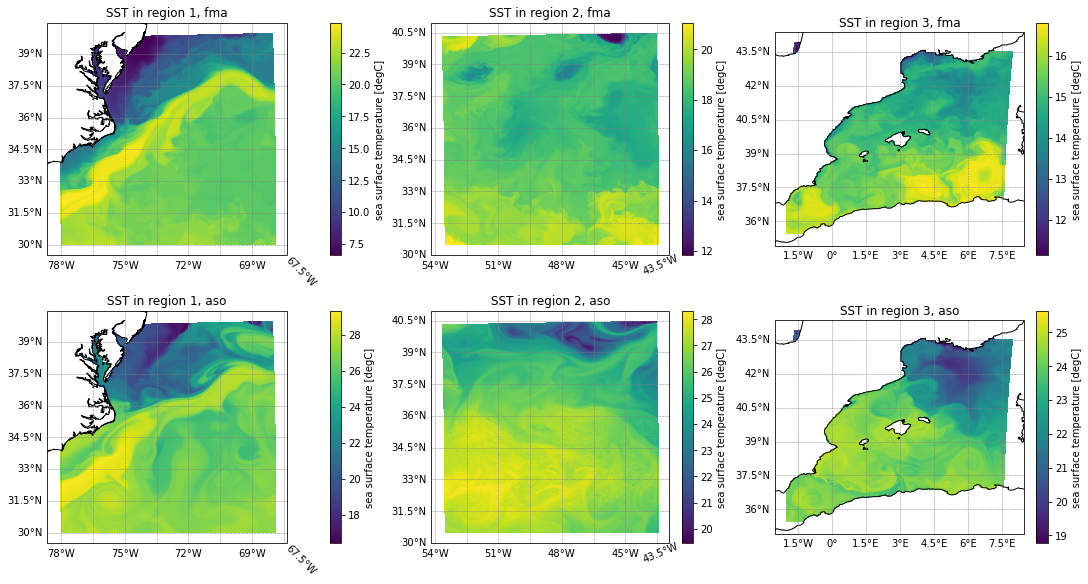

In [15]:
%%time
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsHR :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].isel(time_counter=0).sosstsst[coord_slice].plot(x='lon', y='lat', ax=ax[row,col])
    ax[row,col].set(title='SST in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    ax[row,col].coastlines()
    gl = ax[row,col].gridlines(draw_labels=True, x_inline=False, y_inline=False, 
              color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False
#plt.savefig('Images/SST_vs_region_season.png')

CPU times: user 1.4 s, sys: 29.3 ms, total: 1.43 s
Wall time: 1.42 s


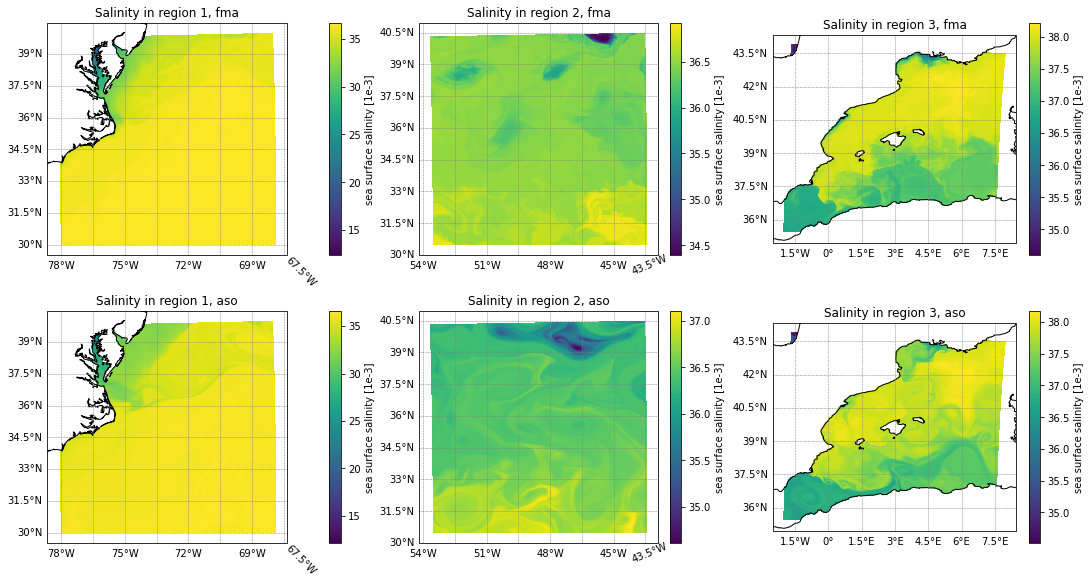

In [16]:
%%time
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsHR :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].isel(time_counter=0).sosaline[coord_slice].plot(x='lon', y='lat', ax=ax[row,col])
    ax[row,col].set(title='Salinity in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    ax[row,col].coastlines()
    gl = ax[row,col].gridlines(draw_labels=True, x_inline=False, y_inline=False, 
              color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False
#plt.savefig('Images/Salinity_vs_region_season.png')

## eORCA025

In [17]:
dataSetsORCA25=[]

for region in ['1', '2', '3'] :
    for season in ['fma', 'aso'] :
        current_set = xr.open_dataset("Data/eORCA025/region"+region+"_"+season+".nc", chunks={'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
        dataSetsORCA25.append({'region': region, 'season' : season, 'data': current_set,'label' : 'eORCA025'})

CPU times: user 403 ms, sys: 21.5 ms, total: 424 ms
Wall time: 657 ms


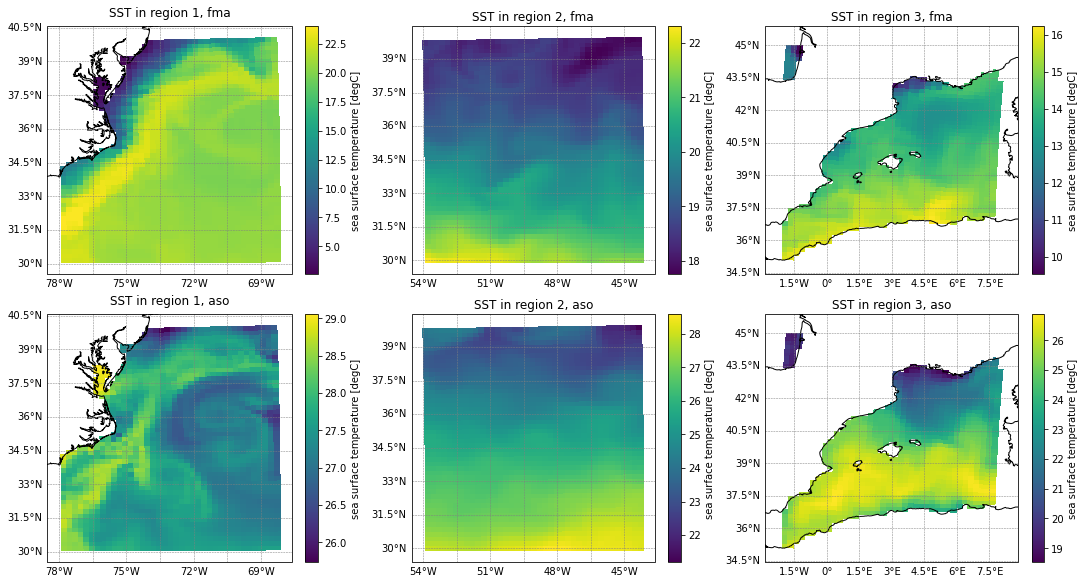

In [18]:
%%time
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8), subplot_kw={'projection': ccrs.PlateCarree()})
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsORCA25 :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].isel(time_counter=0).sosstsst[coord_slice].plot(x='nav_lon', y='nav_lat', ax=ax[row,col])
    ax[row,col].set(title='SST in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
    ax[row,col].coastlines()
    gl = ax[row,col].gridlines(draw_labels=True, x_inline=False, y_inline=False, 
              color='grey', linestyle='dashed', linewidth=0.5)
    gl.top_labels = False; gl.right_labels = False
#plt.savefig('Images/Salinity_vs_region_season.png')

# Filter

Parameters (to determine) :

In [19]:
filter_coef = 32        #relative to the grid size
coarsening_window_size=12

In [20]:
def downsample(data, window_size, area_2d, wet_mask) :
    area_masked = area_2d*wet_mask
    data_weighted = area_masked*data
    data_weighted_sums = data_weighted.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim', \
                                           coord_func={'x':'mean', 'y':'mean', 'lat':'mean', 'lon':'mean'}).sum(skipna=True)
    area_window_sums = area_masked.coarsen(x=coarsening_window_size, y=coarsening_window_size, boundary='trim').sum(skipna=True)
    result = data_weighted_sums/area_window_sums
    result['x'] = np.arange(len(result['x']))
    result['y'] = np.arange(len(result['y']))
    
    # coarsened coordinates:
    new_e1t = data['e1t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=False).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    new_e2t = data['e2t'].coarsen(x=coarsening_window_size,boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).mean(skipna=False).coarsen(y=coarsening_window_size, boundary='trim', coord_func={'x':'sum', 'y':'sum','e1t':'sum', 'e2t':'sum'}).sum(skipna=False).\
drop(['depth', 'e1f', 'e1t', 'e1u', 'e1v', 'e2f', 'e2t', 'e2u', 'e2v', 'lat', 'lon', 'nav_lat', 'nav_lon'])
    result['e1t'] = (['y','x'], new_e1t.values) 
    result['e2t'] = (['y','x'], new_e2t.values) 
    return result

In [21]:
def apply_filter_downsample(dataHR, filter_coef, coarse_window_size) :
    wet_mask = xr.DataArray(dataHR.tmask, dims=['y','x'])
    area = xr.DataArray((dataHR.e1t * dataHR.e2t), dims=['y','x'])
    if (filter_coef > 0) :
        # Filtering with a fixed factor
        dxw = xr.DataArray(dataHR.e1u, dims=['y','x']) # x-spacing centered at western cell edge
        dyw = xr.DataArray(dataHR.e2u, dims=['y','x']) # y-spacing centered at western cell edge
        dxs = xr.DataArray(dataHR.e1v, dims=['y','x']) # x-spacing centered at southern cell edge
        dys = xr.DataArray(dataHR.e2v, dims=['y','x']) # y-spacing centered at southern cell edge
        dx_min = min(dxw.min(),dyw.min(),dxs.min(),dys.min()).values
        dx_max = max(dxw.max(),dys.max()).values
        filter_scale = filter_coef*dx_max
#         kappa_w = xr.ones_like(dxw)
#         kappa_s = xr.ones_like(dxw)
        kappa_w = dxw * dxw / (dx_max * dx_max)
        kappa_s = dys * dys / (dx_max * dx_max)
        # define the filter
        gaussian_filter = gcm_filters.Filter(
            filter_scale=filter_scale,    
            dx_min=dx_min,
            filter_shape=gcm_filters.FilterShape.GAUSSIAN,
            grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
            grid_vars={'wet_mask': wet_mask, 'dxw': dxw, 'dyw': dyw, 'dxs': dxs, 'dys': dys, 'area': area, 
                'kappa_w': kappa_w, 'kappa_s': kappa_s} )
        # apply filter to HR data
        data_filtered = xr.Dataset({}, coords=dataHR.coords)
        data_filtered = gaussian_filter.apply(dataHR, dims=['y', 'x'])
    else :
        data_filtered = dataHR
    # spatial coarsening
    if (coarse_window_size > 0) :
        dataLR = downsample(data_filtered, coarse_window_size, area, wet_mask)
    else : 
        dataLR = data_filtered
    return dataLR

# Downgraded data

In [22]:
dataSetsLR = []

for dataHR in dataSetsHR :
    %time dataLR = apply_filter_downsample(dataHR['data'].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), \
                                           filter_coef, coarsening_window_size).compute().\
    chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    dataSetsLR.append({'region': dataHR['region'], 'season' : dataHR['season'], 'data': dataLR, 'label' : 'Coarse + Filter'})

CPU times: user 2.62 s, sys: 847 ms, total: 3.47 s
Wall time: 32.1 s
CPU times: user 2.53 s, sys: 777 ms, total: 3.31 s
Wall time: 32.4 s
CPU times: user 2.54 s, sys: 714 ms, total: 3.25 s
Wall time: 27.4 s
CPU times: user 2.38 s, sys: 772 ms, total: 3.15 s
Wall time: 27.6 s
CPU times: user 2.35 s, sys: 712 ms, total: 3.07 s
Wall time: 24.4 s
CPU times: user 2.37 s, sys: 749 ms, total: 3.11 s
Wall time: 25.3 s


In [23]:
dataSetsCoarse = []

for dataHR in dataSetsHR :
    %time dataCoarse = apply_filter_downsample(dataHR['data'], 0, coarsening_window_size).compute().\
    chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})
    dataSetsCoarse.append({'region': dataHR['region'], 'season' : dataHR['season'], 'data': dataCoarse, 'label' : 'Coarse'})

CPU times: user 521 ms, sys: 204 ms, total: 725 ms
Wall time: 720 ms
CPU times: user 561 ms, sys: 208 ms, total: 769 ms
Wall time: 768 ms
CPU times: user 514 ms, sys: 180 ms, total: 693 ms
Wall time: 691 ms
CPU times: user 508 ms, sys: 200 ms, total: 708 ms
Wall time: 707 ms
CPU times: user 478 ms, sys: 124 ms, total: 602 ms
Wall time: 601 ms
CPU times: user 452 ms, sys: 160 ms, total: 611 ms
Wall time: 609 ms


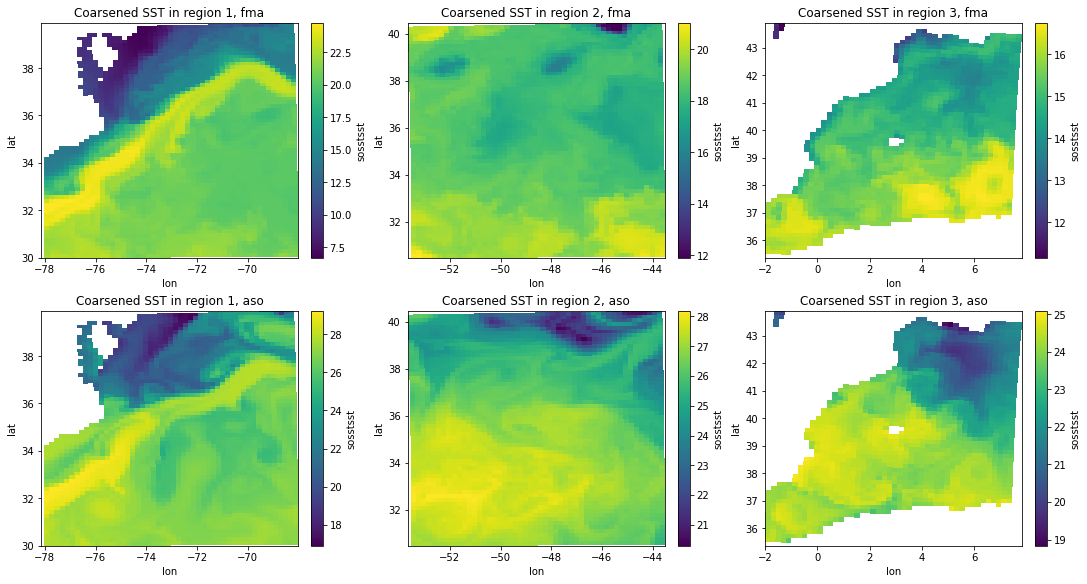

In [24]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsCoarse :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].isel(time_counter=0).sosstsst.plot(x='lon', y='lat', ax=ax[row,col])
    ax[row,col].set(title='Coarsened SST in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
#plt.savefig('Images/SST_filtered_downsampled_vs_region_season.png')

In [25]:
x_slice = slice(0,-1)
y_slice = slice(2,-1)

bord_cut = dict(y=y_slice,x=x_slice)

In [26]:
# %%time
# fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
# for currentDataSet in dataSetsHR :
#     col = int(currentDataSet['region'])-1
#     if (currentDataSet['season'] == 'aso') : row=1
#     if (currentDataSet['season'] == 'fma') : row=0
#     apply_filter_downsample(currentDataSet['data'].isel(time_counter=0).sosstsst, 32, coarsening_window_size).\
#     plot(x='lon', y='lat', ax=ax[row,col])

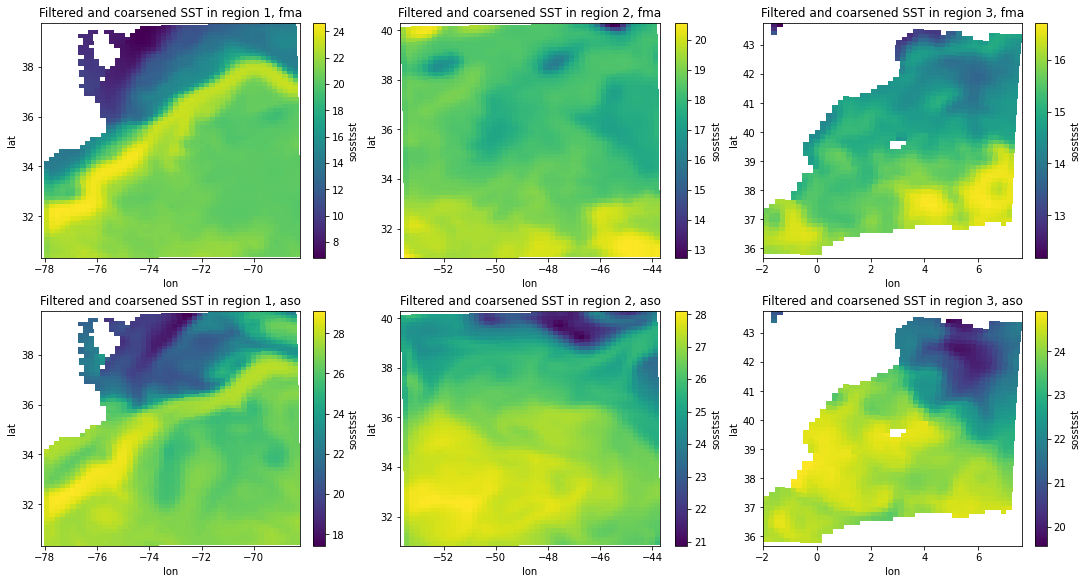

In [27]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
norm = colors.Normalize(vmin=6., vmax=29.)
for currentDataSet in dataSetsLR :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    currentDataSet['data'].isel(time_counter=0).sosstsst[bord_cut].plot(x='lon', y='lat', ax=ax[row,col])
    ax[row,col].set(title='Filtered and coarsened SST in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
#plt.savefig('Images/SST_filtered_downsampled_vs_region_season.png')

In [28]:
# fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
# norm = colors.Normalize(vmin=6., vmax=29.)
# for currentDataSet in dataSetsLR :
#     col = int(currentDataSet['region'])-1
#     if (currentDataSet['season'] == 'aso') : row=1
#     if (currentDataSet['season'] == 'fma') : row=0
#     currentDataSet['data'].e1t[bord_cut].plot(x='lon', y='lat', ax=ax[row,col])
#     ax[row,col].set(title='Filtered and coarsened SST in region ' + currentDataSet['region'] + ', '+currentDataSet['season'])
# #plt.savefig('Images/SST_filtered_downsampled_vs_region_season.png')

# Histograms of salinity and SST

In [29]:
def compute_2D_histogram(dataSet, var1, var2, nb_of_bins, bins=None) :
    if bins is None :
        bins1 = np.linspace(dataSet[var1].min(), dataSet[var1].max(), nb_of_bins)
        bins2 = np.linspace(dataSet[var2].min(), dataSet[var2].max(), nb_of_bins)
    else :
        bins1 = bins[0]; bins2 = bins[1]
    area_weigths = xr.DataArray((dataSet.e1t * dataSet.e2t).where(dataSet.tmask >0), dims=['y','x'])
    #area_weigths.fillna(0.)
    normalized_weights = (area_weigths/area_weigths.sum()).fillna(0.)
    hist = histogram(dataSet[var1].fillna(0), dataSet[var2].fillna(0), bins=[bins1, bins2], weights=normalized_weights, density=False)
    norm_hist = hist/hist.sum()
    return norm_hist

In [30]:
nb_of_bins = 150

In [31]:
%%time
for currentDataSet in (dataSetsLR+dataSetsCoarse+dataSetsORCA25) :
    currentDataSet['histogram_temp_sal'] = compute_2D_histogram(currentDataSet['data'][bord_cut], 'sosaline', 'sosstsst', nb_of_bins).compute()

CPU times: user 1.86 s, sys: 87.6 ms, total: 1.95 s
Wall time: 8.12 s


In [32]:
for currentDataSet in dataSetsHR :
    %time currentDataSet['histogram_temp_sal'] = compute_2D_histogram(currentDataSet['data'].chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1}), \
                                                                      'sosaline', 'sosstsst', nb_of_bins).compute()

CPU times: user 761 ms, sys: 109 ms, total: 871 ms
Wall time: 1.7 s
CPU times: user 827 ms, sys: 110 ms, total: 936 ms
Wall time: 1.67 s
CPU times: user 393 ms, sys: 119 ms, total: 512 ms
Wall time: 1.63 s
CPU times: user 407 ms, sys: 138 ms, total: 545 ms
Wall time: 1.66 s
CPU times: user 781 ms, sys: 55.7 ms, total: 837 ms
Wall time: 1.36 s
CPU times: user 738 ms, sys: 62.2 ms, total: 800 ms
Wall time: 1.36 s


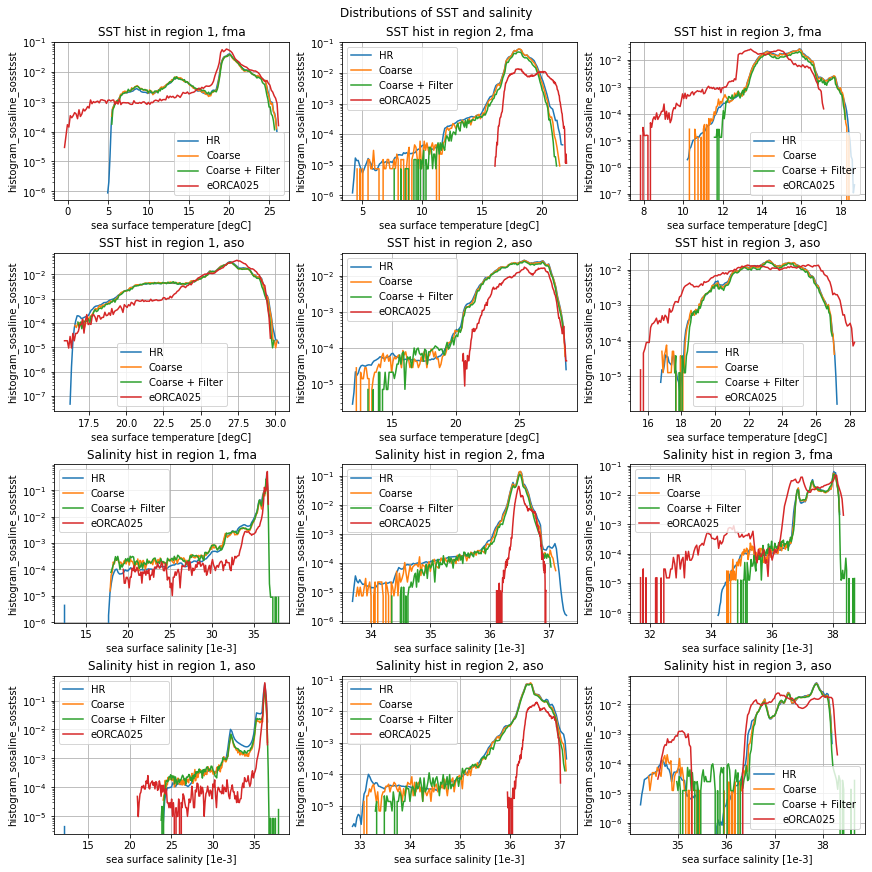

In [33]:
fig, ax = plt.subplots(ncols=3, nrows=4, constrained_layout=True, figsize=(12,12))
fig.suptitle('Distributions of SST and salinity')
for i in range(len(dataSetsLR)) :
    # temperature PDFs
    col = int(dataSetsLR[i]['region'])-1
    if (dataSetsLR[i]['season'] == 'aso') : row=1
    if (dataSetsLR[i]['season'] == 'fma') : row=0
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        hist_temp = dataSet[i]['histogram_temp_sal'].sum(dim='sosaline_bin')
        hist_temp.plot(ax=ax[row,col], label=dataSet[i]['label'])
    ax[row,col].set(yscale='log',title='SST hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)
    # salinity PDFs
    if (dataSetsLR[i]['season'] == 'aso') : row=3
    if (dataSetsLR[i]['season'] == 'fma') : row=2
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        hist_temp = dataSet[i]['histogram_temp_sal'].sum(dim='sosstsst_bin')
        hist_temp.plot(ax=ax[row,col], label=dataSet[i]['label'])
    ax[row,col].set(yscale='log',title='Salinity hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)

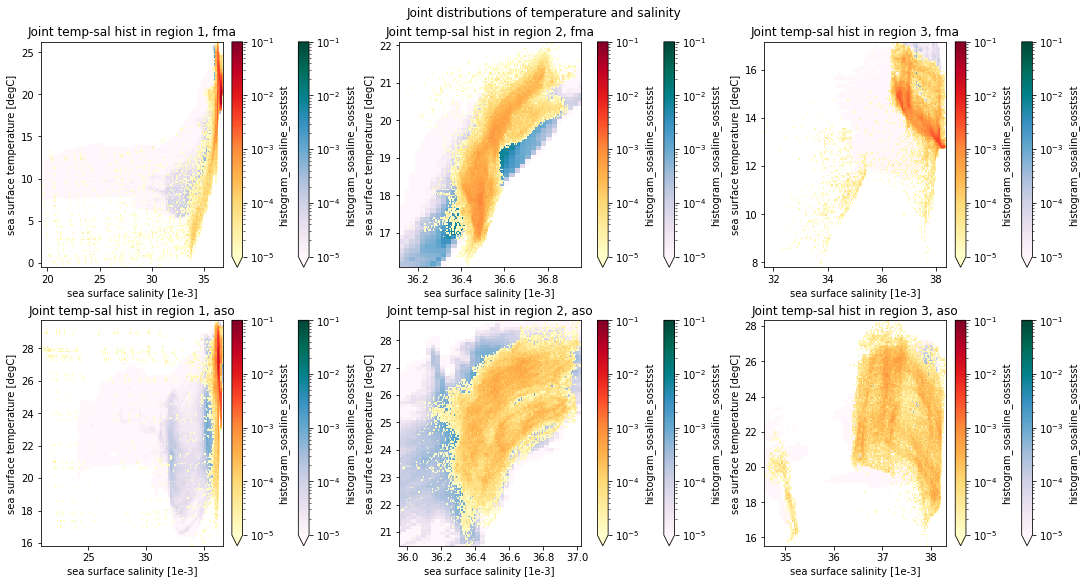

In [34]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
fig.suptitle('Joint distributions of temperature and salinity')
for i,currentDataSet in enumerate(dataSetsLR) :
    col = int(currentDataSet['region'])-1
    if (currentDataSet['season'] == 'aso') : row=1
    if (currentDataSet['season'] == 'fma') : row=0
    dataSetsHR[i]['histogram_temp_sal'].plot(x='sosaline_bin', y='sosstsst_bin', ax=ax[row,col], label='HR',norm=colors.LogNorm(vmin=1e-5, vmax=0.1), cmap='PuBuGn')
    dataSetsORCA25[i]['histogram_temp_sal'].plot(x='sosaline_bin', y='sosstsst_bin', ax=ax[row,col], label='eORCA025',norm=colors.LogNorm(vmin=1e-5, vmax=0.1), cmap='YlOrRd')
    ax[row,col].set(title='Joint temp-sal hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    #ax[row,col].legend()

In [35]:
# fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8), projection='3d')
# fig.suptitle('Joint distributions of temperature and salinity')
# for i,currentDataSet in enumerate(dataSetsLR) :
#     col = int(currentDataSet['region'])-1
#     if (currentDataSet['season'] == 'aso') : row=1
#     if (currentDataSet['season'] == 'fma') : row=0
#     ax[row,col].plot_wireframe('sosaline_bin', 'sosstsst_bin', dataSetsHR[i]['histogram_temp_sal'])
#     ax[row,col].set(title='Joint temp-sal hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
#     #ax[row,col].legend()

# Histograms of gradients of SST

In [36]:
def gradx(dataArray, delta_x) :
    return (dataArray.shift(x=-1) - dataArray)/delta_x
def grady(dataArray, delta_y) :
    return (dataArray.shift(y=-1) - dataArray)/delta_y

In [37]:
def diffx(dataArray) :
    return (dataArray.shift(x=-1) - dataArray)
def diffy(dataArray) :
    return (dataArray.shift(y=-1) - dataArray)

In [38]:
def add_spatial_grad_to_dataset(input_dataset) :
    return xr.merge([input_dataset,
                      xr.DataArray(gradx(input_dataset.sosstsst, input_dataset.e1t), name='gradx_temp'),
                      xr.DataArray(grady(input_dataset.sosstsst, input_dataset.e2t), name='grady_temp'),
                      xr.DataArray(gradx(input_dataset.sosaline, input_dataset.e1t), name='gradx_sal'),
                      xr.DataArray(grady(input_dataset.sosaline, input_dataset.e2t), name='grady_sal'),                      
                      xr.DataArray(np.sqrt(gradx(input_dataset.sosstsst, input_dataset.e1t)**2+\
                                          grady(input_dataset.sosstsst, input_dataset.e2t)**2), name='grad_temp'),
                      xr.DataArray(np.sqrt(gradx(input_dataset.sosaline, input_dataset.e1t)**2+\
                                          grady(input_dataset.sosaline, input_dataset.e2t)**2), name='grad_sal')],compat='override')

In [39]:
%%time
for currentDataSet in (dataSetsLR+dataSetsHR+dataSetsCoarse) :
    currentDataSet['data'] = add_spatial_grad_to_dataset(currentDataSet['data']).compute().chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})

CPU times: user 17.4 s, sys: 7.96 s, total: 25.4 s
Wall time: 30.7 s


In [40]:
%%time
for currentDataSet in dataSetsCoarse :
    currentDataSet['hist_grads'] = compute_2D_histogram(currentDataSet['data'], 'grad_sal', 'grad_temp', nb_of_bins).compute()
    #dataSetsLR[i]['hist_grads'].to_netcdf("Data/Compare_histograms/filter_30km_coarse_12_hist_grad_sal_temp_LR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")
for i in range(len(dataSetsLR)) :
    dataSetsHR[i]['hist_grads'] = compute_2D_histogram(dataSetsHR[i]['data'], 'grad_sal', 'grad_temp', nb_of_bins,\
                                                       bins=[dataSetsCoarse[i]['hist_grads'].grad_sal_bin.values,dataSetsCoarse[i]['hist_grads'].grad_temp_bin.values]).compute()
    dataSetsLR[i]['hist_grads'] = compute_2D_histogram(dataSetsLR[i]['data'][bord_cut], 'grad_sal', 'grad_temp', nb_of_bins,\
                                                       bins=[dataSetsCoarse[i]['hist_grads'].grad_sal_bin.values,dataSetsCoarse[i]['hist_grads'].grad_temp_bin.values]).compute()
    dataSetsORCA25[i]['hist_grads'] = compute_2D_histogram(dataSetsORCA25[i]['data'], 'grad_sal', 'grad_temp', nb_of_bins,\
                                                       bins=[dataSetsCoarse[i]['hist_grads'].grad_sal_bin.values,dataSetsCoarse[i]['hist_grads'].grad_temp_bin.values]).compute()    
    #dataSetsHR[i]['hist_grads'].to_netcdf("Data/Compare_histograms/hist_grad_sal_temp_HR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")
    #dataSetsHR[i]['hist_grads'].to_netcdf("Data/Compare_histograms/coarse_12_hist_grad_sal_temp_LR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")

CPU times: user 2.92 s, sys: 757 ms, total: 3.68 s
Wall time: 11.2 s


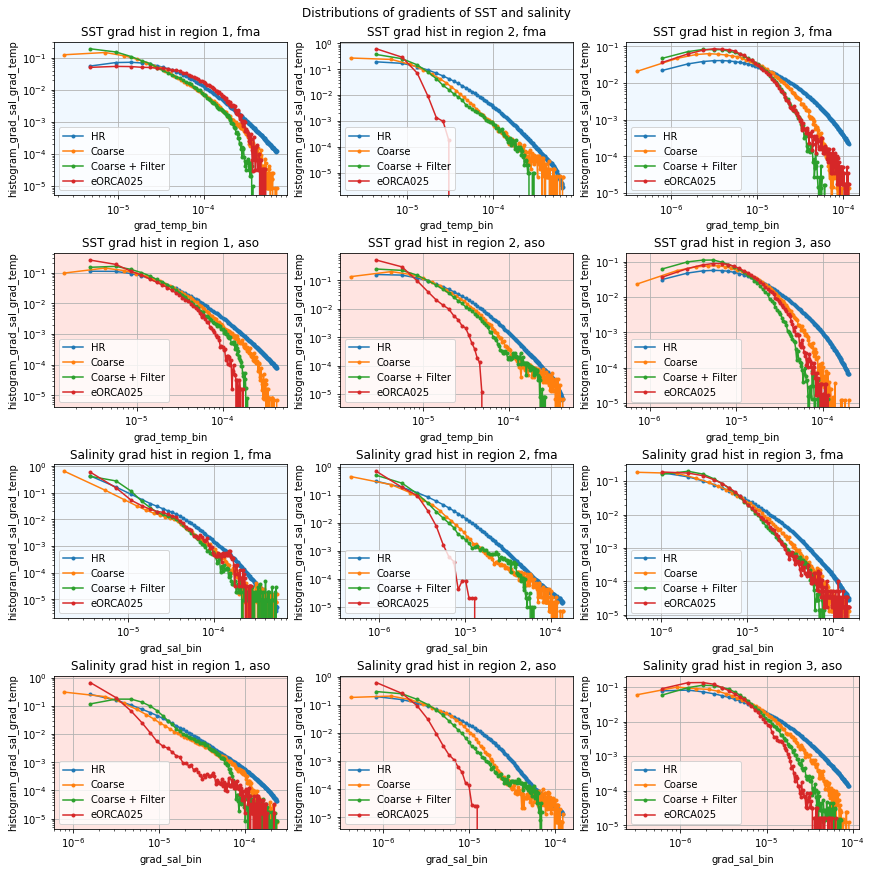

In [41]:
fig, ax = plt.subplots(ncols=3, nrows=4, constrained_layout=True, figsize=(12,12))
fig.suptitle('Distributions of gradients of SST and salinity')
for i in range(len(dataSetsLR)) :
    # temperature PDFs
    col = int(dataSetsLR[i]['region'])-1
    if (dataSetsLR[i]['season'] == 'aso') : 
        row=1; ax[row,col].set_facecolor('mistyrose')
    if (dataSetsLR[i]['season'] == 'fma') : 
        row=0; ax[row,col].set_facecolor('aliceblue')
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        dataSet[i]['hist_grads'].sum(dim='grad_sal_bin').plot(ax=ax[row,col], label=dataSet[i]['label'], ls='-', marker='.')
    ax[row,col].set(yscale='log', xscale='log', title='SST grad hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)
    # salinity PDFs
    if (dataSetsLR[i]['season'] == 'aso') : 
        row=3; ax[row,col].set_facecolor('mistyrose')
    if (dataSetsLR[i]['season'] == 'fma') : 
        row=2; ax[row,col].set_facecolor('aliceblue')
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        dataSet[i]['hist_grads'].sum(dim='grad_temp_bin').plot(ax=ax[row,col], label=dataSet[i]['label'], ls='-', marker='.')
    ax[row,col].set(yscale='log', xscale='log', title='Salinity grad hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)

In [42]:
# fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
# fig.suptitle('Joints distributions of gradients of salinity and temperature')
# for i in range(len(dataSetsLR)) :
#     #histogram_tempLR = xr.open_dataset("Data/Compare_histograms/filter_30km_coarse_12_hist_grad_sal_temp_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
#     #histogram_tempHR = xr.open_dataset("Data/Compare_histograms/hist_grad_sal_temp_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
#     col = int(dataSetsHR[i]['region'])-1
#     if (dataSetsHR[i]['season'] == 'aso') : row=1
#     if (dataSetsHR[i]['season'] == 'fma') : row=0
#     dataSetsHR[i]['hist_grads'].plot(x='grad_sal_bin', y='grad_temp_bin', ax=ax[row,col], label='HR',norm=colors.LogNorm(vmin=1e-5, vmax=1), cmap='PuBuGn')
#     dataSetsLR[i]['hist_grads'].plot(x='grad_sal_bin', y='grad_temp_bin', ax=ax[row,col], label='LR',norm=colors.LogNorm(vmin=1e-5, vmax=1), cmap='YlOrRd')
#     ax[row,col].set(yscale='log', xscale='log', title='Region ' + dataSetsHR[i]['region'] + ', '+dataSetsHR[i]['season'])
#     ax[row,col].set(xlim=[1e-6, 1e-3], ylim=[1e-5, 1e-3])
#     #ax[row,col].legend()

## X-direction gradients

In [43]:
%%time
for i in range(len(dataSetsLR)) :
    dataSetsCoarse[i]['hist_grads_x'] = compute_2D_histogram(dataSetsCoarse[i]['data'][bord_cut], 'gradx_sal', 'gradx_temp', nb_of_bins).compute()
    #dataSetsLR[i]['hist_grads'].to_netcdf("Data/Compare_histograms/filter_30km_coarse_12_hist_grad_sal_temp_LR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")
for i in range(len(dataSetsLR)) :
    dataSetsHR[i]['hist_grads_x'] = compute_2D_histogram(dataSetsHR[i]['data'], 'gradx_sal', 'gradx_temp', nb_of_bins,\
                                                       bins=[dataSetsCoarse[i]['hist_grads_x'].gradx_sal_bin.values,dataSetsCoarse[i]['hist_grads_x'].gradx_temp_bin.values]).compute()
    dataSetsLR[i]['hist_grads_x'] = compute_2D_histogram(dataSetsLR[i]['data'], 'gradx_sal', 'gradx_temp', nb_of_bins,\
                                                       bins=[dataSetsCoarse[i]['hist_grads_x'].gradx_sal_bin.values,dataSetsCoarse[i]['hist_grads_x'].gradx_temp_bin.values]).compute()
    dataSetsORCA25[i]['hist_grads_x'] = compute_2D_histogram(dataSetsORCA25[i]['data'], 'gradx_sal', 'gradx_temp', nb_of_bins,\
                                                       bins=[dataSetsCoarse[i]['hist_grads_x'].gradx_sal_bin.values,dataSetsCoarse[i]['hist_grads_x'].gradx_temp_bin.values]).compute()
    #dataSetsHR[i]['hist_grads'].to_netcdf("Data/Compare_histograms/hist_grad_sal_temp_HR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")
    #dataSetsHR[i]['hist_grads'].to_netcdf("Data/Compare_histograms/coarse_12_hist_grad_sal_temp_LR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")

CPU times: user 2.76 s, sys: 814 ms, total: 3.57 s
Wall time: 11.2 s


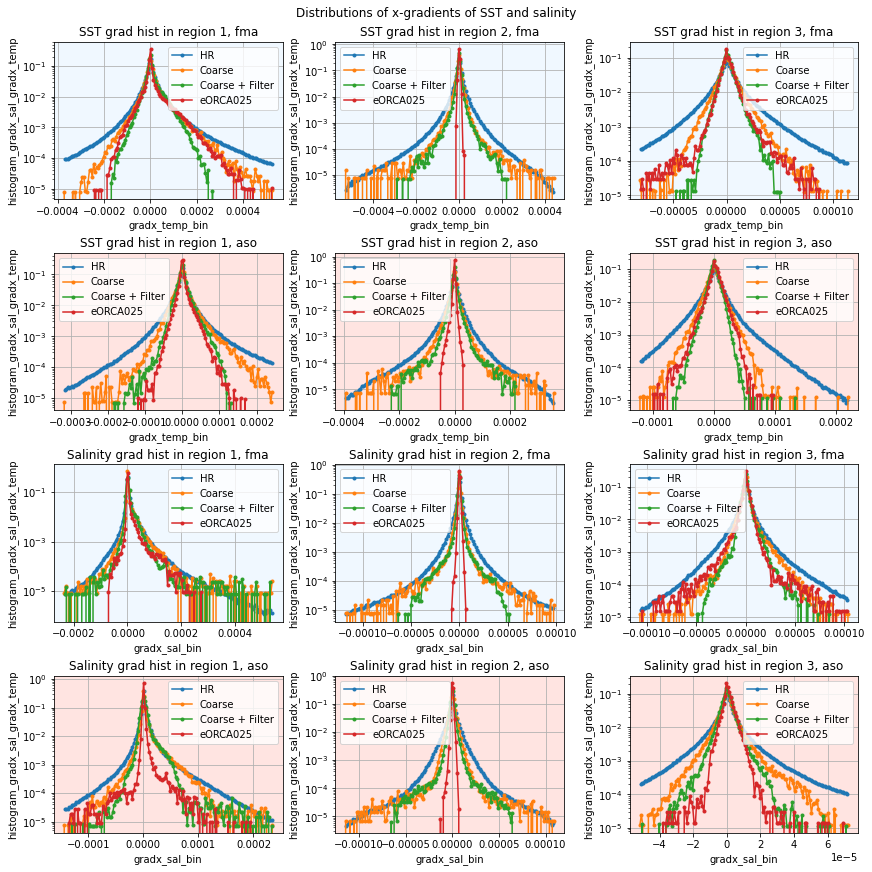

In [44]:
fig, ax = plt.subplots(ncols=3, nrows=4, constrained_layout=True, figsize=(12,12))
fig.suptitle('Distributions of x-gradients of SST and salinity')
for i in range(len(dataSetsLR)) :
    # temperature PDFs
    col = int(dataSetsLR[i]['region'])-1
    if (dataSetsLR[i]['season'] == 'aso') : 
        row=1; ax[row,col].set_facecolor('mistyrose')
    if (dataSetsLR[i]['season'] == 'fma') : 
        row=0; ax[row,col].set_facecolor('aliceblue')
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        dataSet[i]['hist_grads_x'].sum(dim='gradx_sal_bin').plot(ax=ax[row,col], label=dataSet[i]['label'], ls='-', marker='.')
    ax[row,col].set(yscale='log', xscale='linear', title='SST grad hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)
    # salinity PDFs
    if (dataSetsLR[i]['season'] == 'aso') : 
        row=3; ax[row,col].set_facecolor('mistyrose')
    if (dataSetsLR[i]['season'] == 'fma') : 
        row=2; ax[row,col].set_facecolor('aliceblue')
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        dataSet[i]['hist_grads_x'].sum(dim='gradx_temp_bin').plot(ax=ax[row,col], label=dataSet[i]['label'], ls='-', marker='.')
    ax[row,col].set(yscale='log', xscale='linear', title='Salinity grad hist in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)

## Second derivatives of density 

In [45]:
def add_density_derivatives(input_dataset) :
    # conservatice temperature
    CT = xr.apply_ufunc(gsw.conversions.CT_from_pt, input_dataset.sosaline, input_dataset.sosstsst, dask='parallelized')
    alpha, beta = eos_module.alpha_beta(input_dataset.sosaline, CT)
    rho_sa_sa, rho_sa_ct, rho_ct_ct = eos_module.rho_second_derivatives(input_dataset.sosaline, CT)
    return xr.merge([input_dataset,
                      xr.DataArray(alpha, name='alpha'),
                      xr.DataArray(beta, name='beta'),
                      xr.DataArray(rho_sa_sa, name='rho_sa_sa'),
                      xr.DataArray(rho_sa_ct, name='rho_sa_ct'),
                      xr.DataArray(rho_ct_ct, name='rho_ct_ct')])

In [46]:
# %%time
# for currentDataSet in (dataSetsLR+dataSetsHR+dataSetsCoarse) :
#     %time currentDataSet['data'] = add_density_derivatives(currentDataSet['data']).chunk({'time_counter' : nb_of_time_chunks, 'x' : -1, 'y' : -1})

In [47]:
rho0 = 0.1 # for non-dimesionalization

In [48]:
# %%timeit
# for currentDataSet in (dataSetsLR+dataSetsHR) :
#     currentDataSet['data'] = add_density_derivatives(currentDataSet['data'])
#     currentDataSet['data']['non_dim_diff_T_sqr'] = xr.DataArray(1./rho0*np.abs(currentDataSet['data'].rho_ct_ct)*(diffx(currentDataSet['data'].sosstsst)**2+diffy(currentDataSet['data'].sosstsst)**2),\
#                                       name='non_dim_grad_T_sqr')
#     currentDataSet['data']['non_dim_diff_S_sqr'] = xr.DataArray(1./rho0*np.abs(currentDataSet['data'].rho_sa_sa)*(diffx(currentDataSet['data'].sosaline)**2+diffy(currentDataSet['data'].sosaline)**2), \
#                                       name='non_dim_grad_S_sqr')
#     currentDataSet['nondim_hist_diff_temp_sal'] = compute_2D_histogram(currentDataSet['data'], \
#                                                                        'non_dim_diff_T_sqr', 'non_dim_diff_S_sqr', nb_of_bins).compute()
#     #currentDataSet['nondim_hist_diff_temp_sal'].to_netcdf("Data/Compare_histograms/filter_30km_coarse_12_hist_nondim_diff_sal_temp_LR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")
#     #currentDataSet['nondim_hist_diff_temp_sal'].to_netcdf("Data/Compare_histograms/hist_diff_sal_temp_HR_region"+dataSetsLR[i]['region']+"_"+dataSetsLR[i]['season']+".nc")

In [49]:
# fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
# fig.suptitle('Joints distributions of non-dimensional differences of salinity and temperature')
# for i in range(len(dataSetsLR)) :
#     #histogram_tempLR = xr.open_dataset("Data/Compare_histograms/filter_30km_coarse_12_hist_nondim_grad_sal_temp_LR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
#     #histogram_tempHR = xr.open_dataset("Data/Compare_histograms/hist_nondim_grad_sal_temp_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")
#     col = int(dataSetsHR[i]['region'])-1
#     if (dataSetsHR[i]['season'] == 'aso') : row=1
#     if (dataSetsHR[i]['season'] == 'fma') : row=0
#     dataSetsHR[i]['nondim_hist_diff_temp_sal'].plot(x='non_dim_diff_S_sqr_bin', y='non_dim_diff_T_sqr_bin', ax=ax[row,col], label='HR',norm=colors.LogNorm(vmin=1e-5, vmax=1), cmap='PuBuGn')
#     dataSetsLR[i]['nondim_hist_diff_temp_sal'].plot(x='non_dim_diff_S_sqr_bin', y='non_dim_diff_T_sqr_bin', ax=ax[row,col], label='LR',norm=colors.LogNorm(vmin=1e-5, vmax=1), cmap='YlOrRd')
#     ax[row,col].set(title='Region ' + dataSetsHR[i]['region'] + ', '+dataSetsHR[i]['season'])
#     #ax[row,col].legend()

# Statistical moments of SST gradients

In [50]:
keys = ['nobs', 'minmax', 'mean', 'variance', 'skewness', 'kurtosis']

In [51]:
%%time
for currentDataSet in (dataSetsHR+dataSetsORCA25+dataSetsCoarse+dataSetsLR) :
    [currentDataSet['nobs'], currentDataSet['minmax'], currentDataSet['mean'], currentDataSet['variance'], currentDataSet['skewness'], currentDataSet['kurtosis']] \
    = describe(currentDataSet['data'].gradx_temp, axis=None, nan_policy='omit')

CPU times: user 28.2 s, sys: 10.4 s, total: 38.6 s
Wall time: 40.3 s


In [52]:
pd_stat_data = {}

In [53]:
for dict_key in keys :
    combine_table = {'Case':[curDataSet['region']+' '+curDataSet['season'] for curDataSet in dataSetsLR], \
                  'HR': [curDataSet[dict_key] for curDataSet in dataSetsHR],\
                  'eORCA025': [curDataSet[dict_key] for curDataSet in dataSetsORCA25],\
                  'Coarse': [curDataSet[dict_key] for curDataSet in dataSetsCoarse],\
                  'LR': [curDataSet[dict_key] for curDataSet in dataSetsLR]}
    pd_stat_data[dict_key] = pd.DataFrame(combine_table)

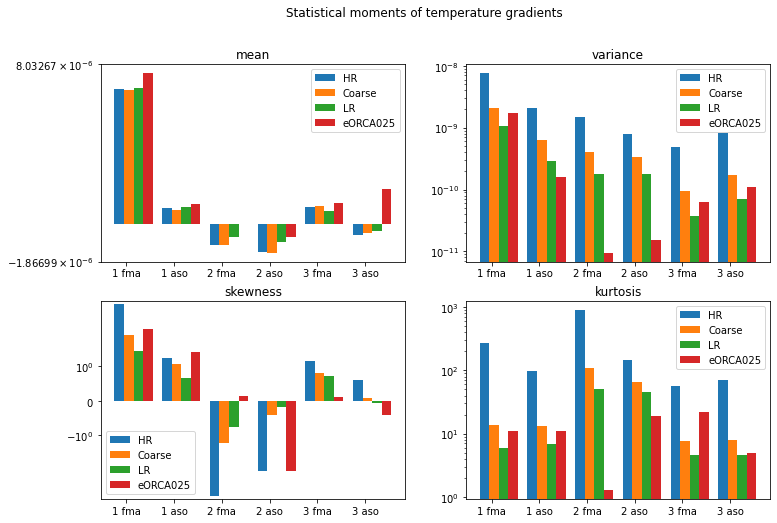

In [54]:
nb_of_rows = 2
nb_of_columns = 2
index_table = np.arange(2,6).reshape(2,2)

fig, ax = plt.subplots(nrows=nb_of_rows, ncols=nb_of_columns, figsize=(12, 8))
fig.suptitle('Statistical moments of temperature gradients')
x = np.arange(len(pd_stat_data['mean'].Case.unique()))
bar_width = 0.2
for plot_index, key_index in np.ndenumerate(index_table) :
    dict_key = keys[key_index]
    b1 = ax[plot_index].bar(x, pd_stat_data[dict_key].HR, width=bar_width, label='HR')
    b2 = ax[plot_index].bar(x+bar_width, pd_stat_data[dict_key].Coarse, width=bar_width, label='Coarse')
    b3 = ax[plot_index].bar(x+2*bar_width, pd_stat_data[dict_key].LR, width=bar_width, label='LR')
    b4 = ax[plot_index].bar(x+3*bar_width, pd_stat_data[dict_key].eORCA025, width=bar_width, label='eORCA025')
    ax[plot_index].set_xticks(x + 0.75*bar_width)
    ax[plot_index].set_xticklabels(pd_stat_data[dict_key].Case.unique())
    if (plot_index[1]== 1) : ax[plot_index].set(title=dict_key, yscale='log')
    if (plot_index[1]== 0) : ax[plot_index].set(title=dict_key, yscale='symlog')
    ax[plot_index].legend()
plt.show()

# Structure functions of SST (x-direction)

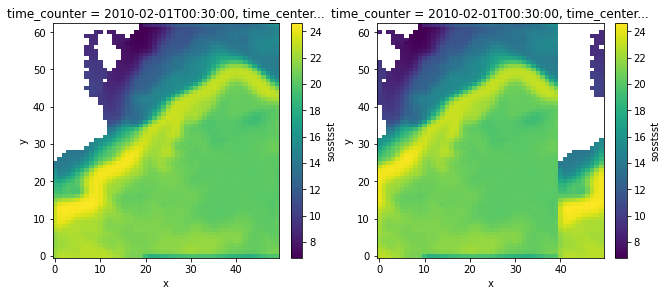

In [55]:
fig, ax = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9,4))
dataArrayToShow = dataSetsLR[0]['data'].isel(time_counter=0).sosstsst
dataArrayToShow.plot(ax=ax[0])
dataArrayToShow.roll(x=-10,roll_coords=False).plot(ax=ax[1])
plt.show()

In [56]:
def compute_structure_functions(dataArr, key_field) :
    N = len(dataArr['x'])
    vectorS1 = np.zeros(N//2-1)
    vectorS2 = np.zeros(N//2-1)
    vectorS3 = np.zeros(N//2-1)
    distance = np.zeros(N//2-1)
    for index,index_shift in enumerate(range(1,N//2)) :
        cut=slice(1,N-index_shift)
        shiftedArr = dataArr[key_field].roll(x=-index_shift,roll_coords=False)
        difference = dataArr[key_field][cut] - shiftedArr[cut]
        vectorS1[index] = difference.mean().values
        vectorS2[index] = (difference**2).mean().values
        vectorS3[index] = (difference**3).mean().values
        distance[index] = dataArr.isel(x=slice(0,index_shift)).e1t.sum(dim='x').mean(dim='y').values
    stucture_functions_dataset = xr.Dataset(data_vars={'S1' : xr.DataArray(vectorS1, dims=["shift"]),\
                                             'S2' : xr.DataArray(vectorS2, dims=["shift"]),\
                                             'S3' : xr.DataArray(vectorS3, dims=["shift"])}, \
                                            coords={'shift' : np.arange(1,N//2),\
                                                   'shift_distance' : ('shift', distance/1000)})
    return stucture_functions_dataset

In [57]:
%%time 
for currentDataSet in (dataSetsLR+dataSetsCoarse+dataSetsORCA25) :
    currentDataSet['temp_str_fun'] = compute_structure_functions(currentDataSet['data'],'sosstsst')

CPU times: user 32.2 s, sys: 1.31 s, total: 33.5 s
Wall time: 2min 30s


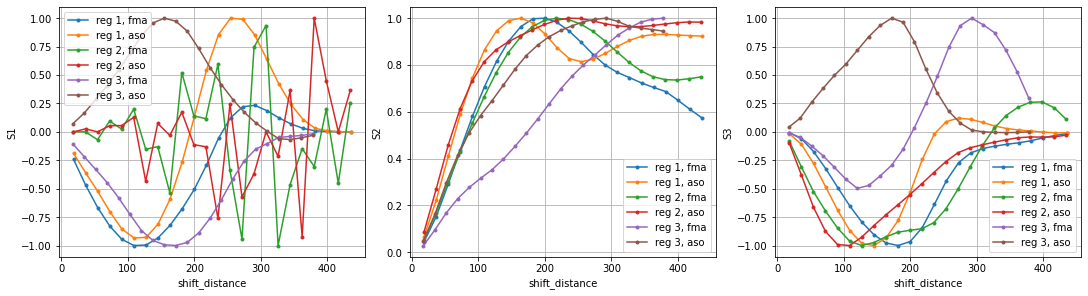

In [58]:
fig, ax = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15,4))
for index, data_key in enumerate(['S1', 'S2', 'S3']) :
    for currentDataSet in (dataSetsLR) :
        data_to_plot = currentDataSet['temp_str_fun'][data_key]
        data_to_plot = data_to_plot/(np.abs(data_to_plot).max())
        data_to_plot.plot(ax=ax[index], x='shift_distance', label='reg '+currentDataSet['region']+', '+currentDataSet['season'], \
                                  marker='.')
    ax[index].set(yscale='linear', xscale='linear'); ax[index].grid(True)
    ax[index].legend()
plt.show()

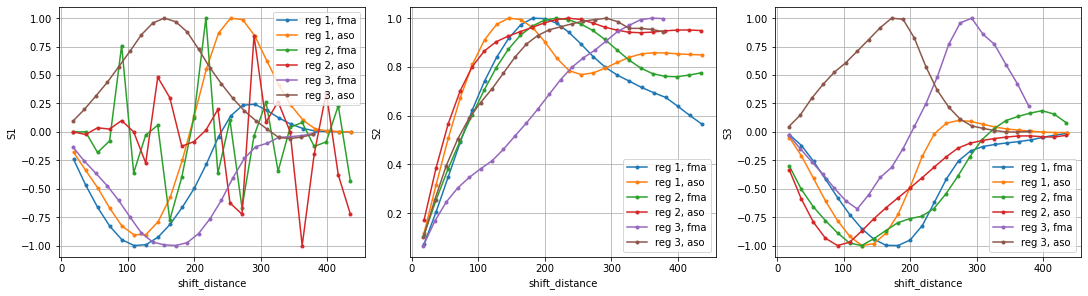

In [59]:
fig, ax = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15,4))
for index, data_key in enumerate(['S1', 'S2', 'S3']) :
    for currentDataSet in (dataSetsCoarse) :
        data_to_plot = currentDataSet['temp_str_fun'][data_key]
        data_to_plot = data_to_plot/(np.abs(data_to_plot).max())
        data_to_plot.plot(ax=ax[index], x='shift_distance', label='reg '+currentDataSet['region']+', '+currentDataSet['season'], \
                                  marker='.')
    ax[index].set(yscale='linear', xscale='linear'); ax[index].grid(True)
    ax[index].legend()
plt.show()

In [60]:
# %%time 
# for currentDataSet in (dataSetsHR) :
#     currentDataSet['temp_str_fun'] = compute_structure_functions(currentDataSet['data'],'sosstsst')

In [61]:
%%time 
for currentDataSet in (dataSetsHR) :
    currentDataSet['temp_str_fun'] = xr.open_dataset("Data/Compare_histograms/temp_str_fun_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")

CPU times: user 26 ms, sys: 963 µs, total: 27 ms
Wall time: 28.7 ms


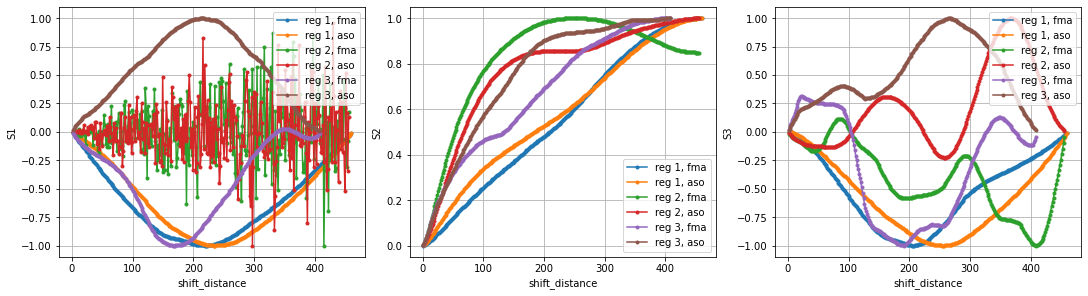

In [62]:
fig, ax = plt.subplots(ncols=3, nrows=1, constrained_layout=True, figsize=(15,4))
for index, data_key in enumerate(['S1', 'S2', 'S3']) :
    for currentDataSet in (dataSetsHR) :
        data_to_plot = currentDataSet['temp_str_fun'][data_key]
        data_to_plot = data_to_plot/(np.abs(data_to_plot).max())
        data_to_plot.plot(ax=ax[index], x='shift_distance', label='reg '+currentDataSet['region']+', '+currentDataSet['season'], \
                                  marker='.')
    ax[index].set(yscale='linear', xscale='linear'); ax[index].grid(True)
    ax[index].legend()
plt.show()

## Compare regions

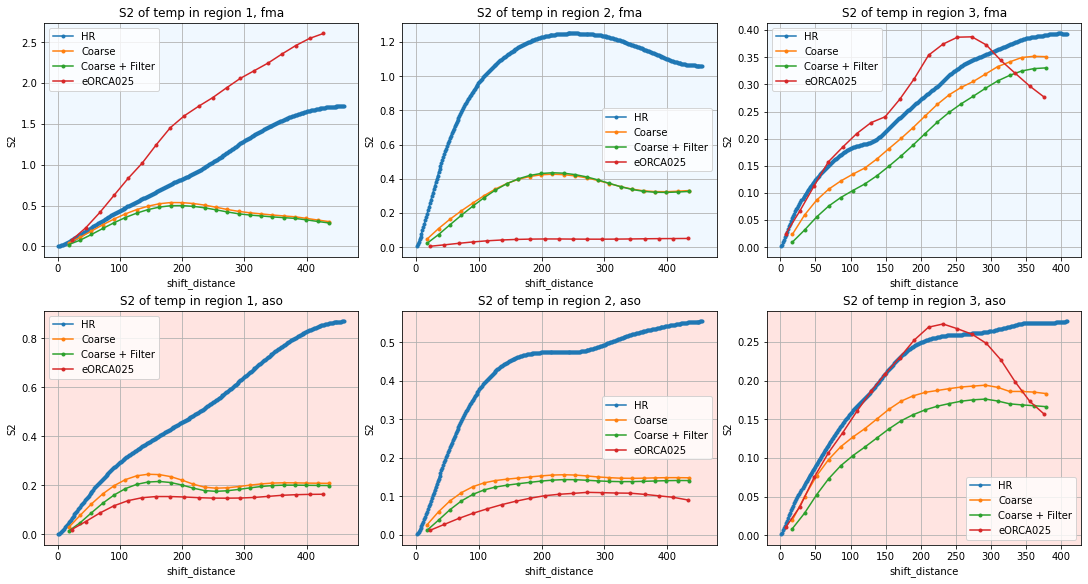

In [63]:
fig, ax = plt.subplots(ncols=3, nrows=2, constrained_layout=True, figsize=(15,8))
for i in range(len(dataSetsLR)) :
    col = int(dataSetsLR[i]['region'])-1
    if (dataSetsLR[i]['season'] == 'aso') : 
        row=1; ax[row,col].set_facecolor('mistyrose')
    if (dataSetsLR[i]['season'] == 'fma') : 
        row=0; ax[row,col].set_facecolor('aliceblue')
    for dataSet in [dataSetsHR, dataSetsCoarse, dataSetsLR, dataSetsORCA25] :
        data = dataSet[i]['temp_str_fun']['S2']
        normalization = (dataSet[i]['data']['sosstsst']).var().values
        data_to_plot = data/normalization
        data_to_plot.plot(x='shift_distance', ax=ax[row,col], label=dataSet[i]['label'], ls='-', marker='.')
    ax[row,col].set(yscale='linear', xscale='linear', title='S2 of temp in region ' + dataSetsLR[i]['region'] + ', '+dataSetsLR[i]['season'])
    ax[row,col].legend(); ax[row,col].grid(True)   

## Write on disk

In [64]:
# for currentDataSet in (dataSetsHR) :
#     currentDataSet['temp_str_fun'].to_netcdf("Data/Compare_histograms/temp_str_fun_HR_region"+currentDataSet['region']+"_"+currentDataSet['season']+".nc")